#  Fashion MNIST Autoencoder

## 1.0 Study purpose

* Build and train an autoencoder for the Fashion MNIST dataset.
* Compress the images into a lower-dimensional representation.
* Reconstruct the original images from the compressed representations.
* Monitor the reconstruction loss during training.
* Evaluate performance by visualizing reconstructed images.

## 2.0 Data Understanding

### 2.1 Prelimary data analysis

#### 2.1.1 Import libraries

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import tensorflow as tf

%matplotlib inline

In [36]:
from matplotlib import pyplot
from keras.datasets import mnist, fashion_mnist, cifar100
from keras.models import Model
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense , Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.constraints import max_norm
from keras.optimizers import Adam ,RMSprop
from keras import backend as K
from subprocess import check_output

#### 2.1.2 Suppress warnings

In [37]:
warnings.filterwarnings('ignore')

#### 2.1.3 Data ingestion

In [38]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

In [39]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


#### 2.1.4 Set random seed

In [40]:
np.random.seed(42)

### 2.2 Data quality

#### 2.2.1 Training data sample images

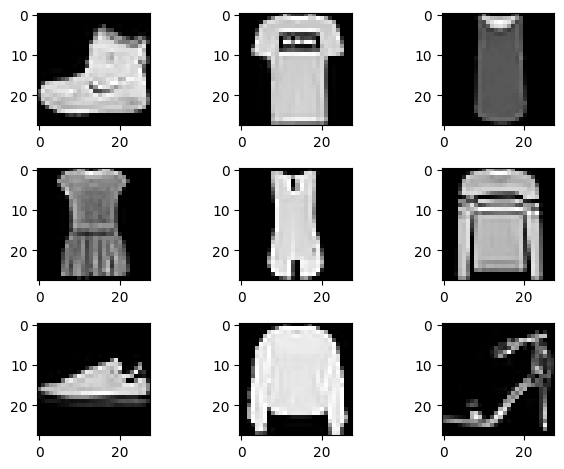

In [41]:
for i in range(9):
    pyplot.subplot(3, 3, i + 1)
    pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))

pyplot.tight_layout()
pyplot.show()

#### 2.2.2 Training label data counts

In [42]:
unique, counts = np.unique(train_y, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

Train labels:  {np.uint8(0): np.int64(6000), np.uint8(1): np.int64(6000), np.uint8(2): np.int64(6000), np.uint8(3): np.int64(6000), np.uint8(4): np.int64(6000), np.uint8(5): np.int64(6000), np.uint8(6): np.int64(6000), np.uint8(7): np.int64(6000), np.uint8(8): np.int64(6000), np.uint8(9): np.int64(6000)}


#### 2.2.3 Testing label data counts

In [43]:
unique, counts = np.unique(test_y, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))


Test labels:  {np.uint8(0): np.int64(1000), np.uint8(1): np.int64(1000), np.uint8(2): np.int64(1000), np.uint8(3): np.int64(1000), np.uint8(4): np.int64(1000), np.uint8(5): np.int64(1000), np.uint8(6): np.int64(1000), np.uint8(7): np.int64(1000), np.uint8(8): np.int64(1000), np.uint8(9): np.int64(1000)}


#### 2.2.4 Label descriptions

1.	T-shirt/top
2.	Trouser
3.	Pullover
4.	Dress
5.	Coat
6.	Sandal
7.	Shirt
8.	Sneaker
9.	Bag
10.	Ankle boot

### 2.3 Exploratory data analysis

## 3.0 Data preprocessing

### 3.1 Compute the number of labels

In [44]:
num_labels = len(np.unique(train_y))
num_labels

10

### 3.2 Encode output data

In [45]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

### 3.3 Image dimensions

In [46]:
image_size = train_X.shape[1]
input_size = image_size * image_size
input_size

784

In [47]:
train_X = np.expand_dims(train_X, axis=-1)

### 3.4 Number of classes

In [48]:
num_classes = test_y.shape[1]

### 3.5 Resize and normalize data

#### 3.5.1 Training data

In [49]:
train_X1 = np.reshape(train_X, [-1, input_size])
train_X1 = train_X1.astype('float32') / 255
train_X = train_X.astype('float32') / 255

In [50]:
print('X1_train: ' + str(train_X1.shape))
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))

X1_train: (60000, 784)
X_train: (60000, 28, 28, 1)
Y_train: (60000, 10)


#### 3.5.2 Testing data

In [51]:
test_X1 = np.reshape(test_X, [-1, input_size])
test_X1 = test_X1.astype('float32') / 255
test_X = test_X.astype('float32') / 255

In [52]:
print('X1_test:  '  + str(test_X1.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X1_test:  (10000, 784)
X_test:  (10000, 28, 28)
Y_test:  (10000, 10)


### 4.0 Modeling

### 4.1 Model input

In [54]:
input_img = Input(shape=(784,))

### 4.2 Encoder layer

In [55]:
encoded = Dense(32, activation='relu')(input_img)

### 4.3 Decoder layer

In [56]:
decoded = Dense(784, activation='sigmoid')(encoded)

### 4.4 Autoencoder model

In [71]:
autoencoder = Model(input_img, decoded)

In [72]:
autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

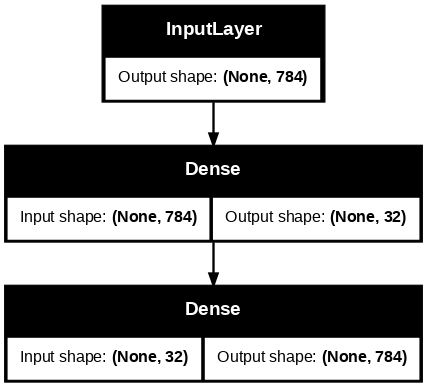

In [73]:
plot_model(autoencoder, to_file='mlp-fashion-mnist-encode.png', show_shapes=True, dpi=84)

### 4.5 Encoder model

In [74]:
encoder = Model(input_img, encoded)

### 4.6 Compile the autoencoder

In [75]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 4.7 Fit the autoencoder

In [76]:
autoencoder.fit(train_X1, train_X1,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(test_X1, test_X1),
                verbose=1)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.0260 - loss: 0.2836 - val_accuracy: 0.0247 - val_loss: 0.2849
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0261 - loss: 0.2824 - val_accuracy: 0.0257 - val_loss: 0.2849
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.0243 - loss: 0.2828 - val_accuracy: 0.0235 - val_loss: 0.2848
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0252 - loss: 0.2826 - val_accuracy: 0.0263 - val_loss: 0.2847
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0274 - loss: 0.2831 - val_accuracy: 0.0262 - val_loss: 0.2848
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0267 - loss: 0.2821 - val_accuracy: 0.0248 - val_loss: 0.2846
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.0261 - loss: 0.2826 - val_accuracy: 0.0250 - val_loss: 0.2847
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0264 - loss: 0.2818 - val_accu

## 5.0 Evaluation

In [77]:
# encoded_images = autoencoder.predict(test_X1)
encoded_images = encoder.predict(test_X1)
predicted = autoencoder.predict(test_X1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


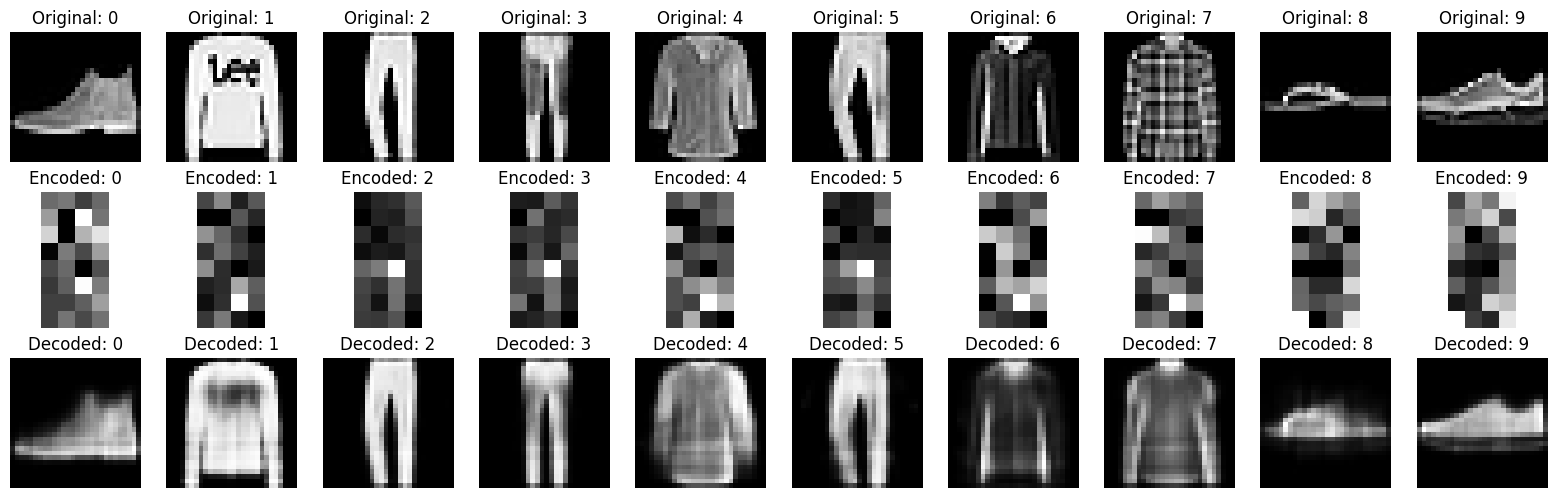

In [80]:
#def plot_mnist_images(original, decoded, n=10):
plt.figure(figsize=(40, 6))
for i in range(10):
  ax = plt.subplot(3, 20, i + 1)
  plt.imshow(test_X1[i].reshape(28, 28), cmap='gray')
  plt.title("Original: {}".format(i))
  plt.axis('off')

  ax = plt.subplot(3, 20, i + 1 + 20)
  plt.imshow(encoded_images[i].reshape(8, 4), cmap='gray')
  plt.title("Encoded: {}".format(i))
  plt.axis('off')

  ax = plt.subplot(3, 20, 2 * 20 + i + 1)
  plt.imshow(predicted[i].reshape(28, 28), cmap='gray')
  plt.title("Decoded: {}".format(i))
  plt.axis('off')
plt.show()

In [ ]:
# plot_mnist_images(test_X1, encoded_images)

## 6.0 Deployment